# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

9.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Mar 17 20:49:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              52W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

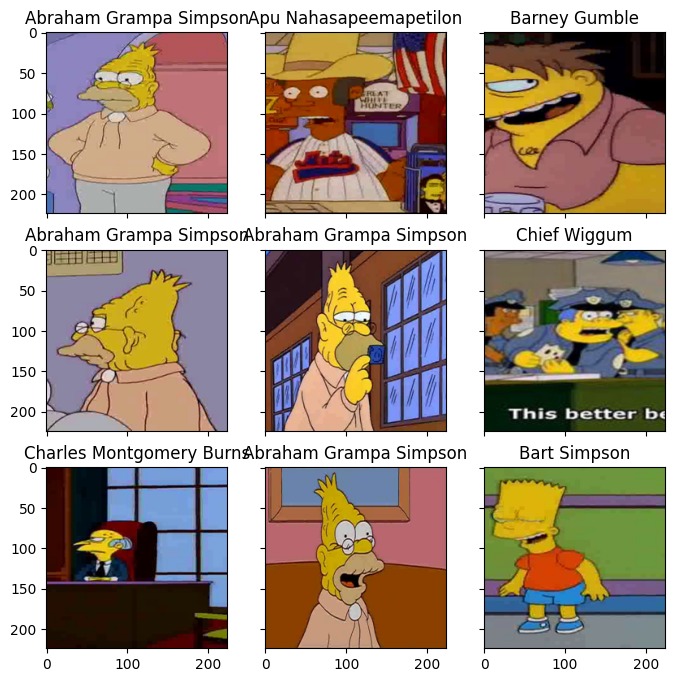

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# # Очень простая сеть
# class SimpleCnn(nn.Module):

#     def __init__(self, n_classes):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.out = nn.Linear(96 * 5 * 5, n_classes)


#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)

#         x = x.view(x.size(0), -1)
#         logits = self.out(x)
#         return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history



In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
# del simple_cnn
# torch.cuda.empty_cache()

In [ ]:
n_classes = len(np.unique(train_val_labels))
# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
# print(simple_cnn)

we will classify :42


Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
# history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=1024)

Построим кривые обучения

In [ ]:
# loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
# plt.figure(figsize=(15, 9))
# plt.plot(loss, label="train_loss")
# plt.plot(val_loss, label="val_loss")
# plt.legend(loc='best')
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
final_model = ef_net
final_model.eval()

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(final_model, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(final_model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

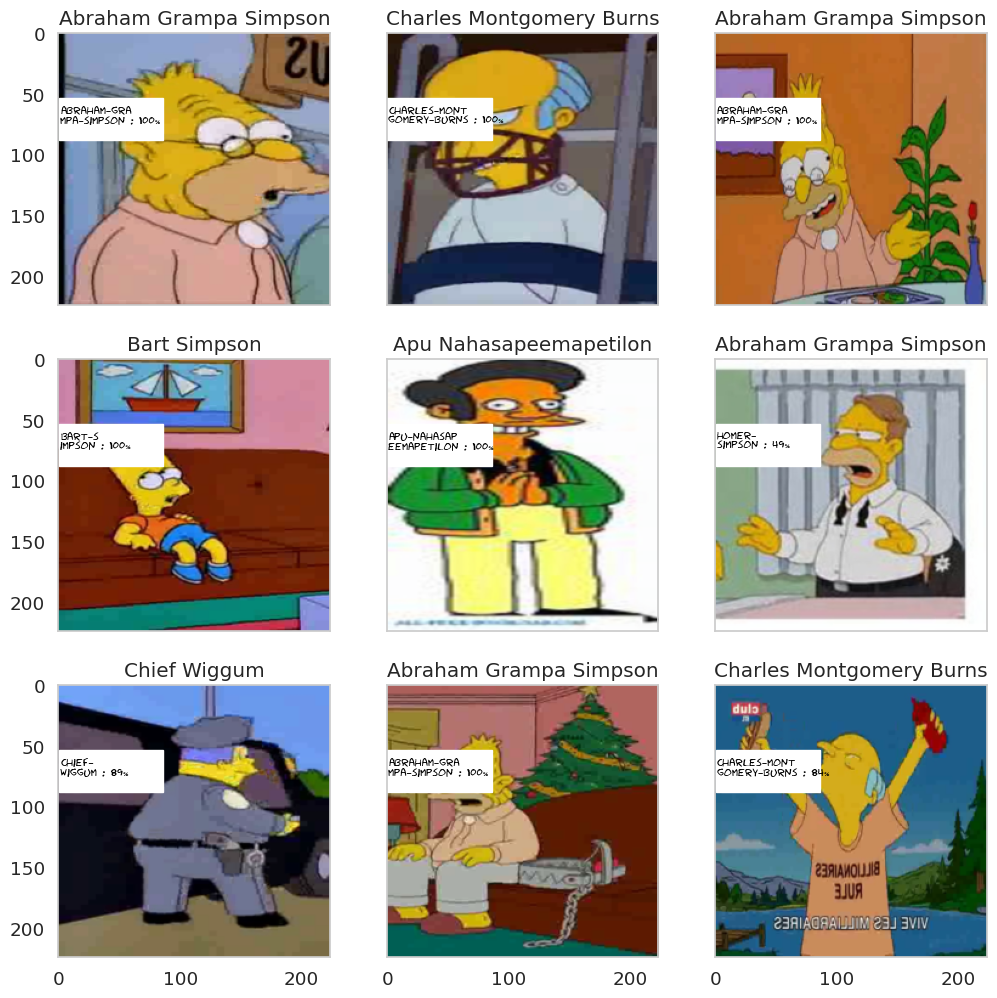

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(final_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
final_model = ef_net
final_model.eval()

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(final_model, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
filename = f'ef_net_b0_w|weights{str(config)[:50]}.csv'
my_submit.to_csv(filename, index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [ ]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :42


In [ ]:
from collections import Counter
counter = Counter(train_val_labels)
print(len(train_val_labels))
counter

20933


Counter({'abraham_grampa_simpson': 913,
         'agnes_skinner': 42,
         'apu_nahasapeemapetilon': 623,
         'barney_gumble': 106,
         'bart_simpson': 1342,
         'carl_carlson': 98,
         'charles_montgomery_burns': 1193,
         'chief_wiggum': 986,
         'cletus_spuckler': 47,
         'comic_book_guy': 469,
         'disco_stu': 8,
         'edna_krabappel': 457,
         'fat_tony': 27,
         'gil': 27,
         'groundskeeper_willie': 121,
         'homer_simpson': 2246,
         'kent_brockman': 498,
         'krusty_the_clown': 1206,
         'lenny_leonard': 310,
         'lionel_hutz': 3,
         'lisa_simpson': 1354,
         'maggie_simpson': 128,
         'marge_simpson': 1291,
         'martin_prince': 71,
         'mayor_quimby': 246,
         'milhouse_van_houten': 1079,
         'miss_hoover': 17,
         'moe_szyslak': 1452,
         'ned_flanders': 1454,
         'nelson_muntz': 358,
         'otto_mann': 32,
         'patty_bouvier': 72

In [ ]:
from sklearn.model_selection import train_test_split

# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        self._transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа

        x = self.load_sample(self.files[index])
        # x = np.array(x.resize((RESCALE_SIZE, RESCALE_SIZE)))
        # x = np.array(x / 255, dtype='float32')
        x = self._transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
weights = []
labels_set = set(train_val_labels)
idx_to_label = {}

for cls in labels_set:
  train_idx = train_dataset.label_encoder.transform([cls])[0]
  val_idx = val_dataset.label_encoder.transform([cls])[0]
  idx_to_label[train_idx] = cls
  assert train_idx==val_idx , f'{cls}'

counter_dict = dict(counter)
max_idx = max(idx_to_label.keys())

for idx in range(max_idx+1):
  curr_weight = len(train_val_labels)/ counter_dict[idx_to_label[idx]]
  # print(curr_weight)
  weights.append(curr_weight)

weights = torch.tensor(weights, dtype=torch.float32)
max_w_value=weights.max().item()
weights/=max_w_value
weights

tensor([0.0033, 0.0714, 0.0048, 0.0283, 0.0022, 0.0306, 0.0025, 0.0030, 0.0638,
        0.0064, 0.3750, 0.0066, 0.1111, 0.1111, 0.0248, 0.0013, 0.0060, 0.0025,
        0.0097, 1.0000, 0.0022, 0.0234, 0.0023, 0.0423, 0.0122, 0.0028, 0.1765,
        0.0021, 0.0021, 0.0084, 0.0938, 0.0417, 0.0025, 0.0462, 0.0667, 0.0337,
        0.0291, 0.0034, 0.0750, 0.0545, 0.3750, 0.0166])

In [ ]:
def eval_epoch(model, val_loader, criterion, scheduler):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    # val_acc = running_corrects.double() / processed_size
    scheduler.step()
    return val_loss

def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    # train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss

def train(train_loader, val_loader, model, epochs,
          optimizer, criterion, scheduler):
    best_model_wts = model.state_dict()
    best_val_loss = np.inf

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            print('------')
            print(f'Epoch: {epoch}, lr: {scheduler.get_last_lr()}')
            train_loss = fit_epoch(model, train_loader, criterion, optimizer)
            #print("loss", train_loss)

            val_loss = eval_epoch(model, val_loader, criterion, scheduler)
            history.append((train_loss, val_loss))


            print(val_loss)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch, t_loss=train_loss,\
                                           v_loss=val_loss))

            if val_loss<=best_val_loss:
                print(f'Update model on the best after epoch #{epoch}')
                best_val_loss = val_loss
                best_model_wts = model.state_dict()


    model.load_state_dict(best_model_wts)
    return history, model

In [ ]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from collections import namedtuple

Config = namedtuple('config', ['model_class', 'lr', 'optimizer_class',
                               'loss_class', 'loss_args',
                               'scheduler_class', 'scheduler_args',
                               'epochs', 'batch_size', 'num_workers'])
config = Config(model_class = models.efficientnet_b0,
               lr=1e-3,
               optimizer_class=optim.AdamW,
               loss_class = nn.CrossEntropyLoss,
               loss_args = dict(weight=weights.to(DEVICE)),
               scheduler_class = lr_scheduler.StepLR,
               scheduler_args = dict(step_size=5, gamma=0.1, verbose=True),
               epochs = 20,
               batch_size=64,
               num_workers=4)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                          shuffle=True, num_workers=config.num_workers)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size,
                        shuffle=False, num_workers=config.num_workers)

ef_net = config.model_class(pretrained=True)
# for param in ef_net.parameters():
  # param.requires_grad = False

num_ftrs = ef_net.classifier[1].in_features
ef_net.classifier[1] = nn.Linear(num_ftrs, n_classes, bias=True)
# for param in ef_net.classifier.parameters():
    # param.requires_grad = True

ef_net = ef_net.cuda()

loss_fn = config.loss_class(**config.loss_args)

optimizer = config.optimizer_class(ef_net.parameters(), lr=config.lr)

scheduler = config.scheduler_class(optimizer, **config.scheduler_args)

print(str(config))
# TODO: F1 score for val

history, ef_net = train(train_loader, val_loader, model=ef_net, epochs=config.epochs,
                        optimizer=optimizer, scheduler = scheduler, criterion = loss_fn )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You 

config(model_class=<function efficientnet_b0 at 0x784e7c795630>, lr=0.001, optimizer_class=<class 'torch.optim.adamw.AdamW'>, loss_class=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, loss_args={'weight': tensor([0.0033, 0.0714, 0.0048, 0.0283, 0.0022, 0.0306, 0.0025, 0.0030, 0.0638,
        0.0064, 0.3750, 0.0066, 0.1111, 0.1111, 0.0248, 0.0013, 0.0060, 0.0025,
        0.0097, 1.0000, 0.0022, 0.0234, 0.0023, 0.0423, 0.0122, 0.0028, 0.1765,
        0.0021, 0.0021, 0.0084, 0.0938, 0.0417, 0.0025, 0.0462, 0.0667, 0.0337,
        0.0291, 0.0034, 0.0750, 0.0545, 0.3750, 0.0166], device='cuda:0')}, scheduler_class=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_args={'step_size': 5, 'gamma': 0.1, 'verbose': True}, epochs=20, batch_size=64, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


epoch:   0%|          | 0/20 [00:00<?, ?it/s]

------
Epoch: 0, lr: [0.001]
0.47491831045063065

Epoch 000 train_loss: 1.5560     val_loss 0.4749
Update model on the best after epoch #0
------
Epoch: 1, lr: [0.001]
0.4759038672089605

Epoch 001 train_loss: 0.5260     val_loss 0.4759
------
Epoch: 2, lr: [0.001]
0.5257644455800741

Epoch 002 train_loss: 0.3450     val_loss 0.5258
------
Epoch: 3, lr: [0.001]
0.4641646300661612

Epoch 003 train_loss: 0.2363     val_loss 0.4642
Update model on the best after epoch #3
------
Epoch: 4, lr: [0.001]
0.30453172914375976

Epoch 004 train_loss: 0.3228     val_loss 0.3045
Update model on the best after epoch #4
------
Epoch: 5, lr: [0.0001]
0.1784655826314412

Epoch 005 train_loss: 0.1032     val_loss 0.1785
Update model on the best after epoch #5
------
Epoch: 6, lr: [0.0001]
0.15263016677811006

Epoch 006 train_loss: 0.0642     val_loss 0.1526
Update model on the best after epoch #6
------
Epoch: 7, lr: [0.0001]
0.1583046424223752

Epoch 007 train_loss: 0.0572     val_loss 0.1583
------
Epo

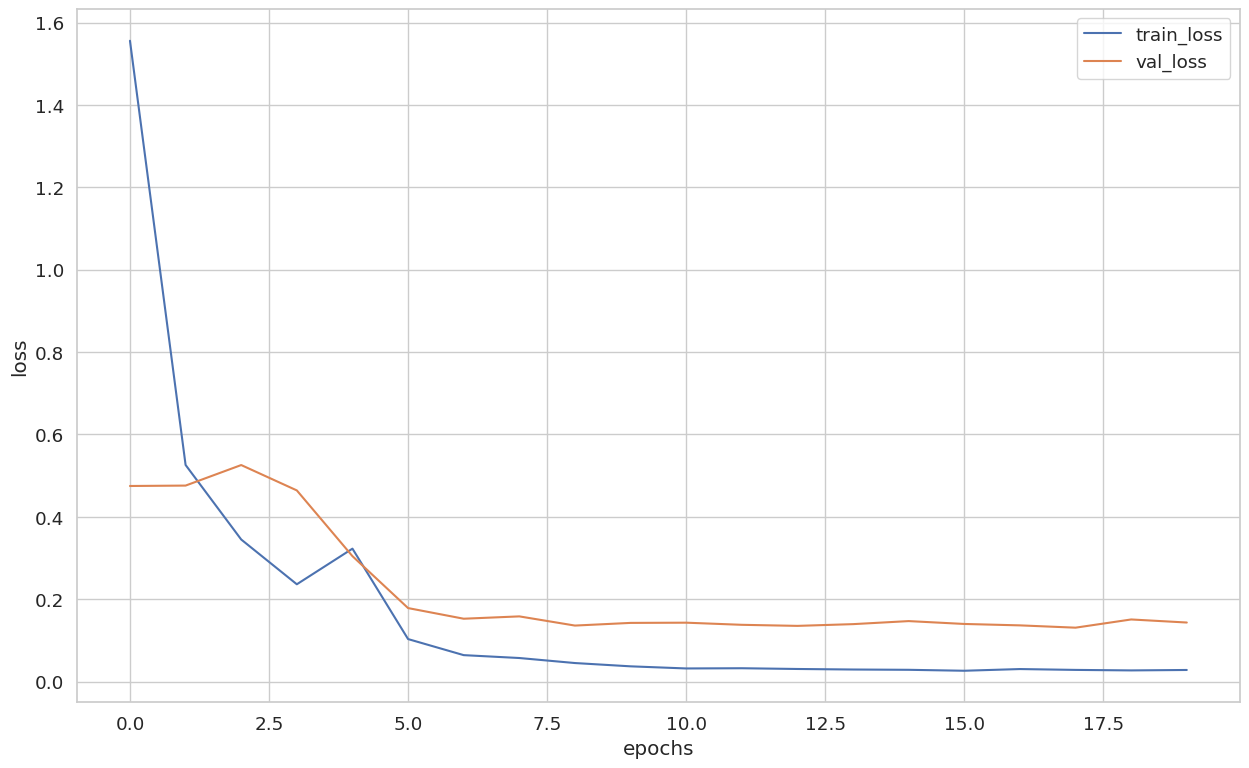

In [ ]:
import seaborn as sns

loss, val_loss = zip(*history)

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
torch.save(ef_net.state_dict(),  f'ef_net_b0_w|weights{str(config)[:50]}.pth')